In [118]:
import os
import pandas as pd
import numpy as np
import sklearn.preprocessing
import scrapbook as sb
import math

import recommenders.models.wide_deep.wide_deep_utils as wide_deep
import recommenders.evaluation.python_evaluation as evaluator

from recommenders.utils import plot
from sklearn.model_selection import train_test_split
from recommenders.datasets.python_splitters import python_random_split
from recommenders.utils import tf_utils
from recommenders.datasets.pandas_df_utils import user_item_pairs

In [93]:
USER_COL = "userID"
ITEM_COL = "itemID"
RATING_COL = "rating"
ITEM_FEAT_COL = "genre"
PREDICT_COL = "prediction"

In [94]:
movie_df = pd.read_csv('./ml-latest-small/movies.csv')
rating_df = pd.read_csv('./ml-latest-small/ratings.csv')
tag_df = pd.read_csv('./ml-latest-small/tags.csv')
links_df = pd.read_csv('./ml-latest-small/links.csv')

In [95]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [96]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [97]:
tag_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [98]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [99]:
data = pd.merge(movie_df, rating_df, on=['movieId'], how='inner')
data = data.drop(['title', 'timestamp'], axis=1)
data = data[['userId', 'movieId', 'rating', 'genres']]
data.columns = [USER_COL, ITEM_COL, RATING_COL, ITEM_FEAT_COL]

In [100]:
genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
    data[ITEM_FEAT_COL].apply(lambda x: x.split("|"))
).tolist()


In [101]:
data.head()

,userID,itemID,rating,genre
0,1,1,4.0,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,5,1,4.0,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,7,1,4.5,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,15,1,2.5,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,17,1,4.5,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [102]:
train, test = python_random_split(data, ratio=0.8, seed=42)

In [103]:
items = data.drop_duplicates(
    ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)

In [104]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9724 entries, 0 to 9723
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   itemID  9724 non-null   int64 
 1   genre   9724 non-null   object
dtypes: int64(1), object(1)
memory usage: 152.1+ KB


In [105]:
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

In [106]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userID  610 non-null    int64
dtypes: int64(1)
memory usage: 4.9 KB


In [107]:
wide_columns, deep_columns = wide_deep.build_feature_columns(
    model_type='wide_deep',
    user_col=USER_COL,
    users=users[USER_COL].values,
    user_dim=16,
    item_col=ITEM_COL,
    items=items[ITEM_COL].values,
    item_dim=16,
    item_feat_col=ITEM_FEAT_COL,
    item_feat_shape=len(items[ITEM_FEAT_COL][0]),
)


In [108]:
print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100])
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100])

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=(1, 5, 7, 15, 17, 18, 19, 21, 27, 31, 
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=(1, 5, 7, 15, 17, 
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=(1,
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(1,
	 NumericColumn(key='genre', shape=(20,), default_value=None, dtype=tf.float32, normalizer_fn=None)


In [109]:
model = wide_deep.build_model(
    model_dir='./models',
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    dnn_hidden_units=[64, 128, 512],
    dnn_dropout=0.4,
    seed=42
)

In [110]:
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    num_epochs=None,
    shuffle=True,
    seed=42,
)

In [111]:
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]

In [112]:
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,
    shuffle=True,
    seed=42
)

In [113]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

In [114]:
hooks = []

evaluation_logger = tf_utils.MetricsLogger()
for metrics in (RANKING_METRICS, RATING_METRICS):
    if len(metrics) > 0:
        hooks.append(
            tf_utils.evaluation_log_hook(
                model,
                logger=evaluation_logger,
                true_df=test,
                y_col=RATING_COL,
                eval_df=ranking_pool if metrics == RANKING_METRICS else test.drop(
                    RATING_COL, axis=1),
                every_n_iter=10000,
                model_dir='./models/',
                eval_fns=[evaluator.metrics[m] for m in metrics],
                **({**cols, 'k': 10} if metrics == RANKING_METRICS else cols)
            )
        )


In [116]:
model.train(
    input_fn=train_fn,
    hooks=hooks,
    steps=50000
)

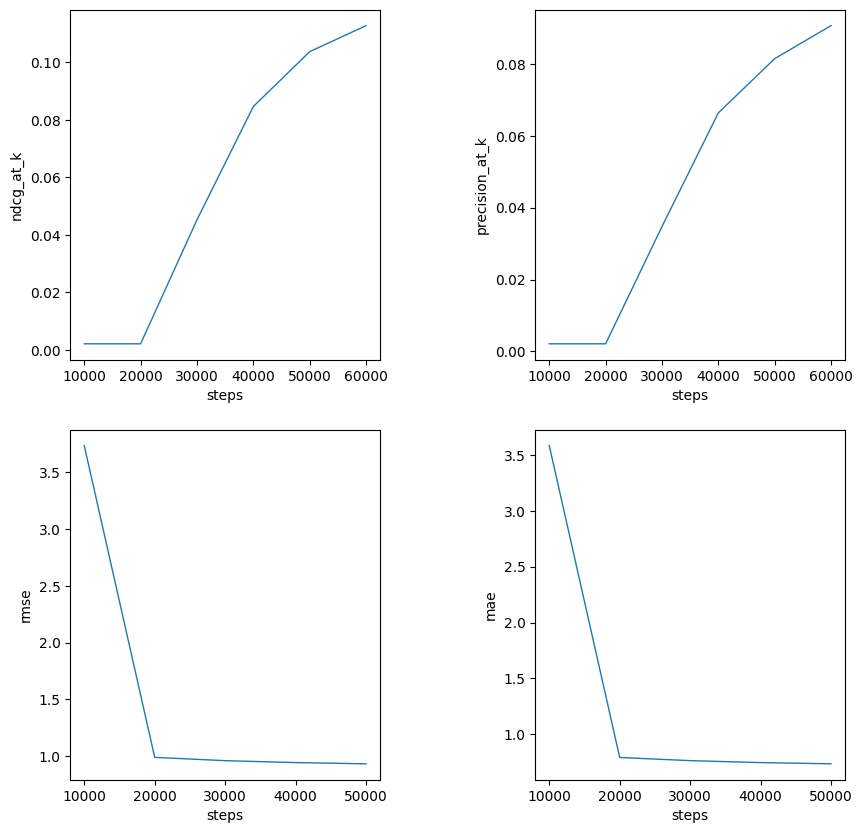

In [119]:
logs = evaluation_logger.get_log()
for i, (m, v) in enumerate(logs.items(), 1):
    sb.glue("eval_{}".format(m), v)
    x = [10000*i for i in range(1, len(v)+1)]
    plot.line_graph(
        values=list(zip(v, x)),
        labels=m,
        x_name="steps",
        y_name=m,
        subplot=(math.ceil(len(logs)/2), 2, i),
    )

In [120]:
predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
prediction_df = test.drop(RATING_COL, axis=1)
prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

rating_results = {}
for m in RATING_METRICS:
    result = evaluator.metrics[m](test, prediction_df, **cols)
    sb.glue(m, result)
    rating_results[m] = result
print(rating_results)


{'rmse': 0.9247885267071349, 'mae': 0.7260845944858741}


In [121]:
predictions = list(model.predict(
 input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
prediction_df = ranking_pool.copy()
prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

ranking_results = {}
for m in RANKING_METRICS:
    result = evaluator.metrics[m](
        test, prediction_df, **{**cols, 'k': 10})
    sb.glue(m, result)
    ranking_results[m] = result
print(ranking_results)


{'ndcg_at_k': 0.11764506999626122, 'precision_at_k': 0.09524590163934428}
